In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gc

#train data 
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import models
from keras import layers

from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
data = pd.read_csv("./chineseMNIST.csv")

In [3]:
#data exploration 
data['label'].unique()

array([        9,        10,       100,      1000,     10000, 100000000,
               0,         1,         2,         3,         4,         5,
               6,         7,         8])

In [4]:
data.to_numpy().shape

(15000, 4098)

In [5]:
#As seen from the label unique function above, there are 15 classes.
data['label'].replace(100,11,inplace=True)
data['label'].replace(1000,12,inplace=True)
data['label'].replace(10000,13,inplace=True)
data['label'].replace(100000000,14,inplace=True)

In [16]:
images = data.drop("label", axis=1).drop("character", axis=1).values
labels = data["label"].values
characters = data["character"].values

images.shape, labels.shape, characters.shape

((15000, 4096), (15000,), (15000,))

In [18]:
# reshape each image in the dataset
def getimage(x):
    pics = [] 
    
    for i in x:
        a = i.reshape(64,64,1)# reshape the flatten data
        pics.append(a)
   
    return np.array(pics).astype('float32')/255 #to the good size

In [41]:
# count dict number
def count(arr):
    dic = {}
    for val in arr:
        if val not in dic.keys():
            dic[val] = 1
        else:
            dic[val] += 1
    return dic 

# target and set labels
def target(chars, num_classes):
    target = [] 
    other = {} # other result
    c = count(chars) # count the characters
   
    for key, i in zip(c.keys(), range(num_classes)):# add labels to the dict
        other[key] = i
        
    labs = other.keys()# create the labels data, the numbers
    for char in chars:
        pos = other[char] # 1
        row = []
        for i in range(num_classes):# [0,1...]-target
            if pos != i:
                row.append(0)
            else:
                row.append(1)
        target.append(row)
    return np.array(target).astype('float32'), other

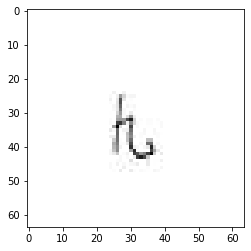

In [11]:
#Test one image
X_labels = data["label"]
X_images = data.drop(labels = ["label", "character"],axis = 1) 

X_images = X_images.values.reshape(-1,64,64,1)

pic = X_images[12] # parameter change : different images of the same character
plt.imshow(pic, cmap=plt.cm.binary)
plt.show()

In [42]:
X = getimage(images)#images as arrays

# get target 
X_lab, other = target(characters, num_classes=15)

X.shape, X.dtype, X_lab.shape, X_lab.dtype

((15000, 64, 64, 1), dtype('float32'), (15000, 15), dtype('float32'))

In [43]:
#train data
x_train, x_test, xl_train, xl_test = train_test_split(X, X_lab, test_size=.2, random_state=0)
x_train.shape, x_test.shape

((12000, 64, 64, 1), (3000, 64, 64, 1))

In [66]:
#Kersa model 

input_shape = (64,64,1) # the dimension of the data
num_classes = 15 # the number of classes

model = Sequential([
    # define the input shape
    layers.InputLayer(input_shape=input_shape),

    # convolutional part with relu and later pooling
    layers.Conv2D(filters=32, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Flatten(),
    
    # dense part
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.2), # turn off random neurons at .2
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.2), 
    layers.Dense(num_classes, activation='softmax')
])



In [67]:
#Compilation
model.compile(
    optimizer='adam',#tried "rmsprop", the accuarcy reached 0.99, may have overfitting issue, thus changed 
    loss='categorical_crossentropy',
    metrics = ['accuracy'],
)



In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               7373056   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [73]:
# fit model 
hist = model.fit(x_train,xl_train,batch_size=64,epochs=25,validation_split=.1,)

Epoch 1/25
169/169 [==============================] - 1s 6ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.2469 - val_accuracy: 0.9400
Epoch 2/25
169/169 [==============================] - 1s 6ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.1952 - val_accuracy: 0.9592
Epoch 3/25
169/169 [==============================] - 1s 7ms/step - loss: 0.0199 - accuracy: 0.9934 - val_loss: 0.2199 - val_accuracy: 0.9550
Epoch 4/25
169/169 [==============================] - 1s 6ms/step - loss: 0.0124 - accuracy: 0.9965 - val_loss: 0.2123 - val_accuracy: 0.9517
Epoch 5/25
169/169 [==============================] - 1s 7ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.2316 - val_accuracy: 0.9533
Epoch 6/25
169/169 [==============================] - 1s 7ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.2329 - val_accuracy: 0.9617
Epoch 7/25
169/169 [==============================] - 1s 7ms/step - loss: 0.0180 - accuracy: 0.9946 - val_loss: 0.2495 - val_accuracy: 0.9583
Epoch 

In [74]:
# Model Evaluation
results = model.evaluate(x_test, xl_test, batch_size=64)
print("[test loss, test acc]:", results)

47/47 [==============================] - 0s 4ms/step - loss: 0.2463 - accuracy: 0.9557
[test loss, test acc]: [0.2462683916091919, 0.9556666612625122]


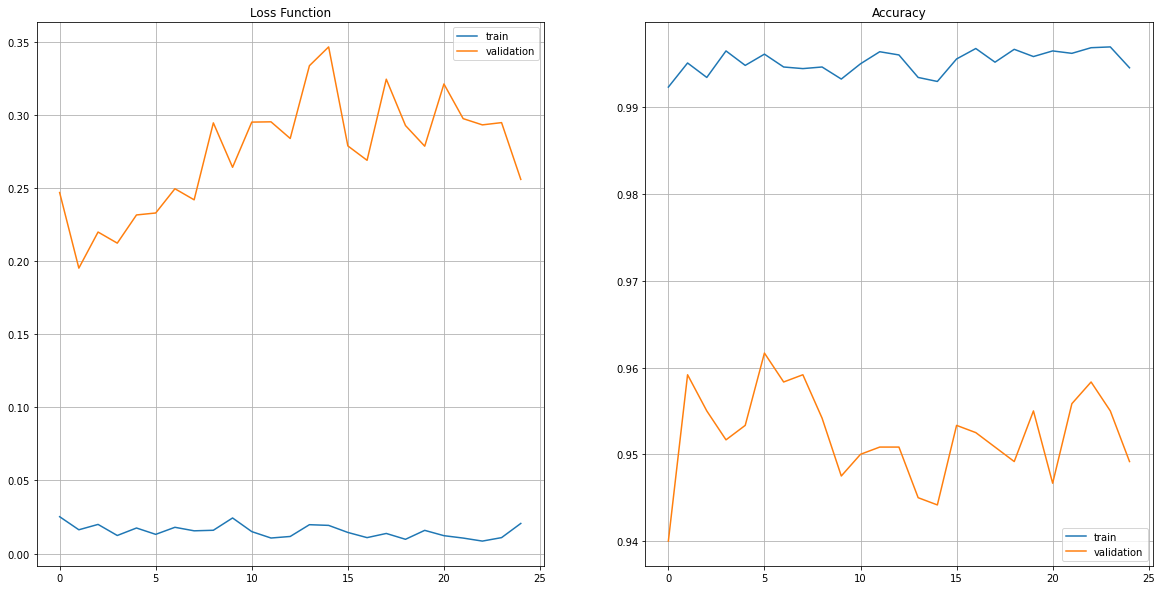

In [75]:
plt.figure(figsize=(20, 10))

# plot the loss function
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Function')
plt.grid(True)
plt.legend()

# plot the accuracy
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.grid(True)
plt.title('Accuracy')
plt.legend()

plt.show()

The model reaches a performance of almost 0.95 in validation and testing and .99 in training.